<a href="https://colab.research.google.com/github/vigneshK0404/NOva_Fitter_CNF/blob/main/CNF_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo
!pip install nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=c4a067261dd6ff1786d7c1adc04eb4cc7b02b68be2713022dcba55bfdaca14d3
  Stored in directory: /root/.cache/pip/wheels/fd/27/c3/8952205ea17b63dc1eaa24031e63111c6a3661cb22cc1e2a3c
Successfully built nflows


In [2]:
import torch
import torchinfo
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader
import time

In [3]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import (
    CompositeTransform,
)
from nflows.transforms.autoregressive import (
    MaskedAffineAutoregressiveTransform,
)
from nflows.transforms.autoregressive import (
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform,
)
from nflows.transforms.permutations import ReversePermutation

In [4]:
dnumber = 0
device = torch.device(f"cuda:{dnumber}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
minN1 = 50
maxN1 = 100

minN2 = 50
maxN2 = 70

minmu1 = 3
maxmu1 = 6

minmu2 = 12
maxmu2 = 15

minsig1 = 1
maxsig1 = 3

minsig2 = 1
maxsig2 = 3

def gauss(N,mu,sig,x):
    N_t = N.reshape(-1,1)
    mu_t = mu.reshape(-1,1)
    sig_t = sig.reshape(-1,1)

    term1 = N_t / (sig_t * np.sqrt(2 * np.pi))
    term2 = np.exp(-0.5 * np.square((x - mu_t) / sig_t))
    return np.array(term1 * term2)

def generatePrior(sampleSize):
    N1 = np.random.uniform(minN1,maxN1,sampleSize)
    N2 = np.random.uniform(minN2,maxN2,sampleSize)

    mu1 = np.random.uniform(minmu1,maxmu1,sampleSize)
    mu2 = np.random.uniform(minmu2,maxmu2,sampleSize)

    sig1 = np.random.uniform(minsig1,maxsig1,sampleSize)
    sig2 = np.random.uniform(minsig2,maxsig2,sampleSize)

    return N1,mu1,sig1,N2,mu2,sig2

def generateTrainingData(uniqueNum, sampleNum):
  minX_center = 0.5
  maxX_edge = 20.5
  step = 0.5 # -> bin width

  rawBins = np.arange(minX_center,maxX_edge,step=step)
  genP = generatePrior(uniqueNum)
  N1,mu1,sig1,N2,mu2,sig2 = genP

  gaussSample = step * (gauss(N1,mu1,sig1,rawBins) + gauss(N2, mu2, sig2,rawBins))
  fullGaussMatrix = np.repeat(gaussSample,repeats=sampleNum,axis=0)

  thetaData = np.column_stack(genP)
  fullthetaData = np.repeat(thetaData,repeats=sampleNum,axis=0)

  rng = np.random.default_rng()
  dataPoisson = rng.poisson(lam=fullGaussMatrix,size=None)

  return dataPoisson, fullthetaData, fullGaussMatrix




[[3.42308872e+00 4.33116702e+00 5.26175666e+00 6.13755842e+00
  6.87384240e+00 7.39166972e+00 7.63175794e+00 7.56564001e+00
  7.20121555e+00 6.58119867e+00 5.77488406e+00 4.86542615e+00
  3.93586808e+00 3.05721293e+00 2.28116372e+00 1.63961378e+00
  1.15364730e+00 8.56340755e-01 8.30434775e-01 1.24258566e+00
  2.31998614e+00 4.20526027e+00 6.71431547e+00 9.19246880e+00
  1.07139830e+01 1.06087058e+01 8.91841038e+00 6.36401383e+00
  3.85441291e+00 1.98132104e+00 8.64400923e-01 3.20064339e-01
  1.00582215e-01 2.68268322e-02 6.07279201e-03 1.16679383e-03
  1.90294783e-04 2.63509896e-05 3.10050367e-06 3.10741346e-07]]
[[ 3  1  5  8  7  9 11  9  5  5 11  6  0  3  0  3  1  4  0  0  1  9  2 10
   9 14 13  2  4  1  0  0  0  0  0  0  0  0  0  0]]


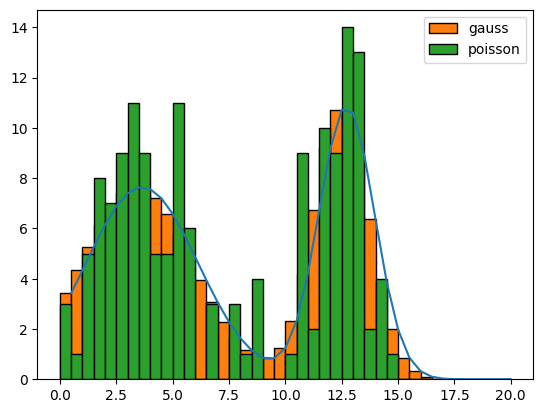

In [6]:
def plots(dP,fG,binEdges):
  plt.plot(binEdges[1:],fG.flatten())
  plt.hist(binEdges[:-1],binEdges,weights=fG.flatten(),edgecolor='black',label='gauss')
  plt.hist(binEdges[:-1],binEdges,weights=dP.flatten(),edgecolor='black',label='poisson')
  plt.legend()


dP,tD, fG = generateTrainingData(1,1)
binEdges = np.arange(0,20.5,0.5)
plots(dP,fG,binEdges)

print(fG)
print(dP)



In [7]:
dataPoisson, thetaData, _ = generateTrainingData(10000,1024)

In [8]:
print(dataPoisson.shape)
print(thetaData.shape)

(10240000, 40)
(10240000, 6)


In [9]:
class autoEncoder(torch.nn.Module):
  def __init__(self, input_dim, output_dim, middle_dim):
    super().__init__()

    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim,middle_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(middle_dim,output_dim)
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(output_dim,middle_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(middle_dim,input_dim),
    )

  def encode(self,x):
    return self.encoder(x)

  def decode(self,x):
    return self.decoder(x)

  def forward(self,x):
    eData = self.encode(x)
    dData = self.decode(eData)
    return dData

In [10]:
input_dim = dataPoisson.shape[-1]
output_dim = 25
middle_dim = 32

encodeModel = autoEncoder(input_dim,output_dim, middle_dim).to(device)
reconOptim = torch.optim.Adam(encodeModel.parameters(), lr = 1e-4)
print(torchinfo.summary(encodeModel))
rloss = torch.nn.MSELoss()

Layer (type:depth-idx)                   Param #
autoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,312
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       825
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       832
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       1,320
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0


100%|██████████| 5/5 [03:43<00:00, 44.77s/it]

5


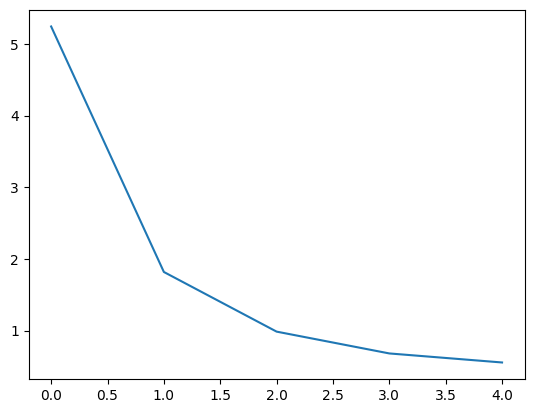

In [11]:
max_iter = 5
r_losses = []
Datasets = DataLoader(dataPoisson, batch_size = 4096, shuffle=True)

for iter in tqdm.tqdm(range(max_iter)):
  iter_losses = []
  for x_batch in Datasets:
      x_batch = x_batch.to(device, non_blocking=True).float()
      reconOptim.zero_grad()
      y_pred = encodeModel(x_batch)
      loss = rloss(y_pred, x_batch)
      iter_losses.append(loss.item())
      loss.backward()
      reconOptim.step()

  r_losses.append(np.mean(np.array(iter_losses)))

print(len(r_losses))
plt.plot(r_losses)

0.5545476914525032
[ 3.3156366   5.324175    9.721276    7.949079   13.911164    9.93834
 17.019926   13.978202    5.986145    2.9919887   3.9683964   4.018639
  0.9596756   0.68854415  1.7501401  -1.0563909   0.43646187 -0.44198805
  0.69548726  0.4108465   1.391105    1.6566083   0.79704905  0.8996358
  4.965333    7.0852885   4.961748    2.8584843   3.780371    7.8349686
  1.7210028   3.0881727   2.275682    3.614548    2.3544781   1.927262
  1.0755907   0.71338767  0.42233896  0.2417689 ]
[ 6.  4.  9.  8. 14. 10. 17. 14.  6.  3.  4.  4.  1.  0.  2.  0.  0.  0.
  0.  1.  0.  2.  1.  1.  5.  7.  5.  3.  4.  8.  2.  1.  2.  5.  1.  5.
  3.  2.  2.  0.]


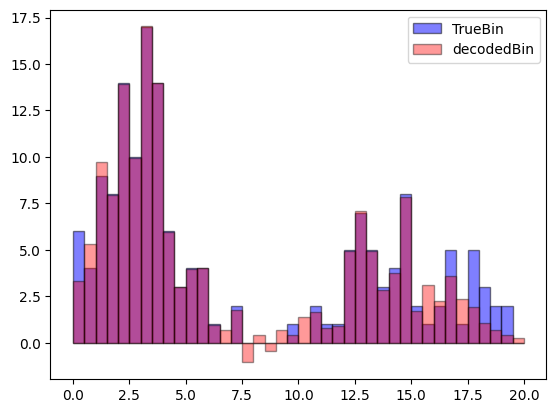

In [12]:
print(r_losses[-1])
testP,_ ,_= generateTrainingData(1,1)
testP = torch.tensor(testP, dtype = torch.float32)
testP = testP.to(device)
decodePtest = encodeModel(testP).to("cpu").detach().numpy().flatten()
testP_CPU = testP.to("cpu").detach().numpy().flatten()

print(decodePtest)
print(testP_CPU)

bins = np.arange(0,20.5,0.5)
plt.hist(bins[:-1], bins,weights=testP_CPU,color='blue',edgecolor='black',alpha=0.5,label="TrueBin")
plt.hist(bins[:-1], bins,weights=decodePtest,color='red',edgecolor='black',alpha=0.4,label="decodedBin")
plt.legend()

In [30]:
class CNF():
  def __init__(self,n_features, context_features,n_layers):

    base_dist = StandardNormal(shape=[n_features])
    transforms = []

    for i in range(n_layers):
      transforms.append(MaskedAffineAutoregressiveTransform(features=n_features, hidden_features=16, context_features=context_features)) #we are conditioning on 6 column data Ni,MUi and Stdi i{1,2}
      transforms.append(ReversePermutation(features=n_features))

    transform = CompositeTransform(transforms)
    self.flow = Flow(transform,base_dist)


In [31]:
n_features = 6
contextF = output_dim

CNFModel = CNF(n_features,context_features= contextF,n_layers=10).flow.to(device)
flowOptim = torch.optim.Adam(CNFModel.parameters(), lr = 1e-3)

print(torchinfo.summary(CNFModel))

Layer (type:depth-idx)                                       Param #
Flow                                                         --
├─CompositeTransform: 1-1                                    --
│    └─ModuleList: 2-1                                       --
│    │    └─MaskedAffineAutoregressiveTransform: 3-1         2,652
│    │    └─ReversePermutation: 3-2                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-3         2,652
│    │    └─ReversePermutation: 3-4                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-5         2,652
│    │    └─ReversePermutation: 3-6                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-7         2,652
│    │    └─ReversePermutation: 3-8                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-9         2,652
│    │    └─ReversePermutation: 3-10                         --
│    │    └─MaskedAffineAutoregressiveTransform: 3-11        2,652
│    │    └─Rever

In [28]:
tMeans = np.mean(thetaData,axis=0)
tStDev = np.std(thetaData,axis=0)

print(tMeans, tStDev)

thetaData_standard = (thetaData - tMeans)/tStDev

[74.85086413  4.49515967  1.98902672 60.02614114 13.50837843  2.00039489] [14.4952107   0.8682181   0.57595911  5.75628165  0.86441843  0.58072533]


In [23]:
print(thetaData_standard)

[[-0.44927092 -0.17848891 -1.3793523   0.54443469  0.24092016  1.42127346]
 [-0.44927092 -0.17848891 -1.3793523   0.54443469  0.24092016  1.42127346]
 [-0.44927092 -0.17848891 -1.3793523   0.54443469  0.24092016  1.42127346]
 ...
 [-1.70778379 -0.1083455   0.22106331  1.14584592  0.01778738  1.07117726]
 [-1.70778379 -0.1083455   0.22106331  1.14584592  0.01778738  1.07117726]
 [-1.70778379 -0.1083455   0.22106331  1.14584592  0.01778738  1.07117726]]


In [24]:
test_batch = 512
torch.autograd.set_detect_anomaly(True)
pData_sample = torch.tensor(dataPoisson[0:test_batch], device = device).float()
tData_sample = torch.tensor(thetaData_standard[0:test_batch], device = device).float()

pEn_sample = encodeModel.encode(pData_sample)
flowOptim.zero_grad()

nll = -CNFModel.log_prob(tData_sample, context=pEn_sample)
cnf_loss = nll.mean()

print(cnf_loss.item())
cnf_loss.backward()
flowOptim.step()

3010150.75


In [32]:
batch_size = 512
num_iter = 5 #reduce number of iterations this converges a lot quicker

max_batch = int(dataPoisson.shape[0] / batch_size)

logLoss = []

for i in tqdm.tqdm(range(num_iter)):
  permut = np.random.permutation(dataPoisson.shape[0])
  dataPoisson_shufle = dataPoisson[permut]
  thetaData_shuffle = thetaData_standard[permut]

  for i_batch in range(max_batch):
    start = i_batch * batch_size
    end = start + batch_size

    pData = torch.tensor(dataPoisson_shufle[start:end], device = device).float()
    tData = torch.tensor(thetaData_shuffle[start:end], device = device).float()

    pData_encoded = encodeModel.encode(pData)

    flowOptim.zero_grad()

    nll = -CNFModel.log_prob(tData, context=pData_encoded)

    cnf_loss = nll.mean()
    logLoss.append(cnf_loss.item())

    if(i_batch % 10 == 0):
      print(f"nll:{cnf_loss}")


    cnf_loss.backward()
    flowOptim.step()





  0%|          | 0/5 [00:00<?, ?it/s]

nll:15289828352.0
nll:57.949031829833984
nll:57.79022216796875
nll:52.72218322753906
nll:47.66988754272461
nll:45.44320297241211
nll:207.70875549316406
nll:41.500244140625
nll:41.332035064697266
nll:38.98627471923828
nll:36.438392639160156
nll:35.36964416503906
nll:33.773292541503906
nll:33.004669189453125
nll:31.89692497253418
nll:30.672943115234375
nll:29.92269515991211
nll:29.506412506103516
nll:57.895023345947266
nll:29.702281951904297
nll:29.469636917114258
nll:27.720129013061523
nll:26.42000389099121
nll:26.93841552734375
nll:26.639053344726562
nll:26.846839904785156
nll:27.095077514648438
nll:25.49065589904785
nll:25.35382843017578
nll:29.609262466430664
nll:30.9437198638916
nll:31.82636260986328
nll:31.458492279052734
nll:32.15196228027344
nll:31.5181884765625
nll:30.362314224243164
nll:29.959758758544922
nll:27.210065841674805
nll:27.239002227783203
nll:27.83802032470703
nll:27.153514862060547
nll:26.47005844116211
nll:26.42792510986328
nll:25.642807006835938
nll:26.1542606353

 20%|██        | 1/5 [1:09:33<4:38:12, 4173.05s/it]

nll:1778.0150146484375
nll:1859.78125
nll:1767.2510986328125
nll:37528280.0
nll:1840.4481201171875
nll:1816.30078125
nll:1869.9599609375
nll:1991.24169921875
nll:2008.629150390625
nll:1776.886962890625
nll:1825.3001708984375
nll:1854.666259765625
nll:2002.4046630859375
nll:1930.0970458984375
nll:1769.677001953125
nll:1826.39306640625
nll:1794.75634765625
nll:1816.7769775390625
nll:1838.126220703125
nll:1813.1500244140625
nll:1716.255615234375
nll:1774.180908203125
nll:1645.465576171875
nll:1692.8131103515625
nll:1687.845703125
nll:1746.6142578125
nll:1639.6112060546875
nll:1862.1876220703125
nll:1731.283203125
nll:1642.371826171875
nll:1720.510986328125
nll:1712.745849609375
nll:1638.62939453125
nll:1758.612548828125
nll:1612.29248046875
nll:1678.3006591796875
nll:1596.6376953125
nll:1701.2470703125
nll:1648.3428955078125
nll:1617.6417236328125
nll:1554.198974609375
nll:1615.9971923828125
nll:1628.3094482421875
nll:1577.2548828125
nll:1601.55126953125
nll:1579.69091796875
nll:1649.3864

 20%|██        | 1/5 [1:22:47<5:31:09, 4967.43s/it]


KeyboardInterrupt: 